In [10]:
import os, sys
import csv
import scipy.io
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import (
    find_calib_file,
    calculate_frame_brightness,
    find_brightness_drop,


)
def load_mini_timestamps(csv_path):
    timestamps = []
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            frame_number, timestamp_ms, _ = row
            timestamps.append(int(timestamp_ms))
    return timestamps

#for dannce:
def find_calib_file(base_folder):
    for file_name in os.listdir(base_folder):
        if file_name.endswith('label3d_dannce.mat'):
            return os.path.join(base_folder, file_name)
    return None

def load_frametimes_6cam(base_path, num_cameras=6):
    """
    Load frametimes.npy files for a specified number of cameras.

    Parameters:
    - base_path (str): The base path where the main folder is located.
    - num_cameras (int): The number of cameras to load frametimes for. Default is 6.

    Returns:
    - dict: A dictionary with camera names as keys and frametimes data as values.
    """
    frametimes = {}
    for i in range(1, num_cameras + 1):
        camera_path = f'{base_path}/videos/Camera{i}/frametimes.npy'
        try:
            frametimes[f'Camera{i}'] = np.load(camera_path)
            print(f"Loaded frametimes for Camera{i}")
        except FileNotFoundError:
            print(f"File not found: {camera_path}")
    return frametimes


In [ ]:
def find_camera_with_frame_start(base_folder):
    calib_file = find_calib_file(rec_path)
    calib_data = scipy.io.loadmat(calib_file)
    sync_data = calib_data['sync']
    for cam_idx in range(sync_data.shape[0]):
        cam_sync = sync_data[cam_idx][0]
        data_frame = cam_sync['data_frame'][0][0][0]  # Directly access the known key
        if data_frame[0] == 1:
            print(f"Camera index with data_frame starting at 1: {cam_idx}")
            return cam_idx
    print("No camera with data_frame starting at 1 found.")
    return None
    
# def find_camera_with_frame_start(sync_data):
#     for cam_idx in range(sync_data.shape[0]):
#         cam_sync = sync_data[cam_idx][0]
#         keys = cam_sync.dtype.names
#         for key in keys:
#             data_frame = cam_sync[key][0][0][0]
#             if data_frame[0] == 1:
#                 print(f"Camera index with data_frame starting at 1: {cam_idx}")
#                 print(f"Key used: {key}")
#                 return cam_idx, key
#     print("No camera with data_frame starting at 1 found.")
#     return None, None

# calib_file = find_calib_file(rec_path)
# calib_data = scipy.io.loadmat(calib_file)
# sync = calib_data['sync']
# camera_index, key_used = find_camera_with_frame_start(sync)

In [7]:
rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'

mini_cam_path = os.path.join(mini_path, 'My_First_WebCam')
mini_cam_timestamps = os.path.join(mini_cam_path, 'timeStamps.csv')
mini_cam_vid = os.path.join(mini_cam_path, '0.avi')

miniscope_path = os.path.join(mini_path, 'My_V4_Miniscope')
miniscope_timestamps = os.path.join(miniscope_path, 'timeStamps.csv')



camera_index = find_camera_with_frame_start(rec_path)

Camera index with data_frame starting at 1: 0


In [18]:
# Set the frame range for processing
max_frames_mini = 300  # Adjust as needed
min_frames_mini = 0

# Calculate frame brightness
brightness_values_mini = calculate_frame_brightness(mini_cam_vid, max_frames_mini, min_frames_mini)


In [19]:
# Construct the video path for the selected camera
camera_number = camera_index + 1  # If camera indices start from 0
sixcam_video_path = f'{rec_path}/videos/Camera{camera_number}/0.mp4'

# Set the frame range for processing
max_frames_sixcam = 300  # Adjust as needed
min_frames_sixcam = 0

# Calculate frame brightness
brightness_values_sixcam = calculate_frame_brightness(sixcam_video_path, max_frames_sixcam, min_frames_sixcam)


In [22]:
# Define thresholds (adjust based on your data)
threshold_mini = 3  # Example value
threshold_sixcam = 3  # Example value

drop_indices_mini = find_brightness_drop(brightness_values_mini, threshold_mini)
print(f"Intensity drops in mini_cam_vid at frames: {drop_indices_mini}")


Intensity drops in mini_cam_vid at frames: [32, 49, 50, 53, 104, 129, 130, 133]


In [26]:
drop_indices_mini = find_brightness_drop(brightness_values_mini, threshold_mini)
print(f"Intensity drops in mini_cam_vid at frames: {drop_indices_mini}")
drop_indices_sixcam = find_brightness_drop(brightness_values_sixcam, threshold_sixcam)

Intensity drops in mini_cam_vid at frames: [32, 49, 50, 53, 104, 129, 130, 133]


Synchronization frame in mini_cam_vid: 32
Synchronization frame in sixcam_video: 152


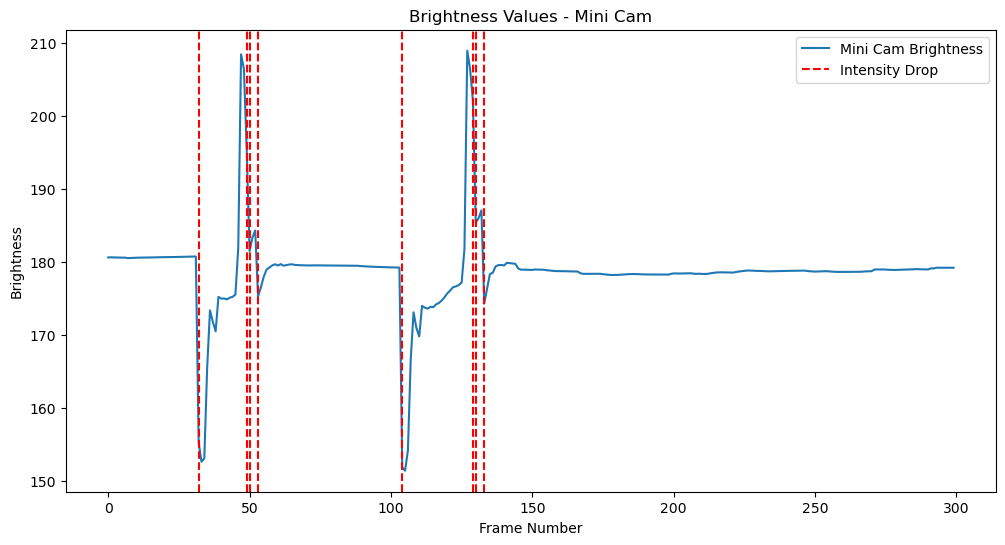

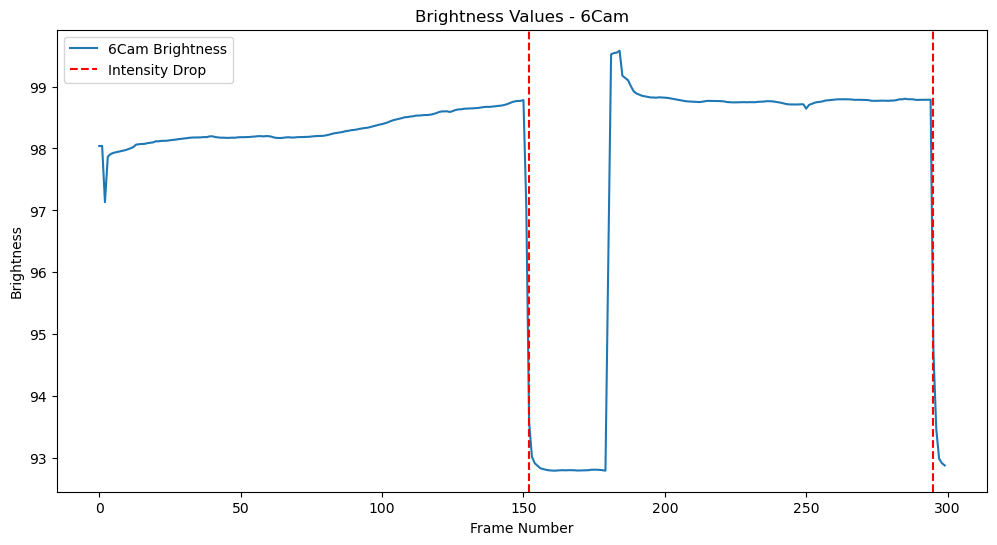

In [27]:


# Print synchronization frames
if drop_indices_mini:
    sync_frame_mini = drop_indices_mini[0]
    print(f"Synchronization frame in mini_cam_vid: {sync_frame_mini}")
else:
    print("No intensity drop found in mini_cam_vid.")

if drop_indices_sixcam:
    sync_frame_sixcam = drop_indices_sixcam[0]
    print(f"Synchronization frame in sixcam_video: {sync_frame_sixcam}")
else:
    print("No intensity drop found in sixcam_video.")

# Plotting for verification
# Mini Cam
plt.figure(figsize=(12, 6))
plt.plot(brightness_values_mini, label='Mini Cam Brightness')
for idx in drop_indices_mini:
    plt.axvline(idx, color='red', linestyle='--', label='Intensity Drop' if idx == drop_indices_mini[0] else "")
plt.title('Brightness Values - Mini Cam')
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.legend()
plt.show()

# 6Cam
plt.figure(figsize=(12, 6))
plt.plot(brightness_values_sixcam, label='6Cam Brightness')
for idx in drop_indices_sixcam:
    plt.axvline(idx, color='red', linestyle='--', label='Intensity Drop' if idx == drop_indices_sixcam[0] else "")
plt.title('Brightness Values - 6Cam')
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.legend()
plt.show()


Camera index with data_frame starting at 1: 0
Intensity drops in mini_cam_vid at frames: [32, 104]
Intensity drops in sixcam_video at frames: [152, 295]
Synchronization frame in mini_cam_vid: 32
Synchronization frame in sixcam_video: 152


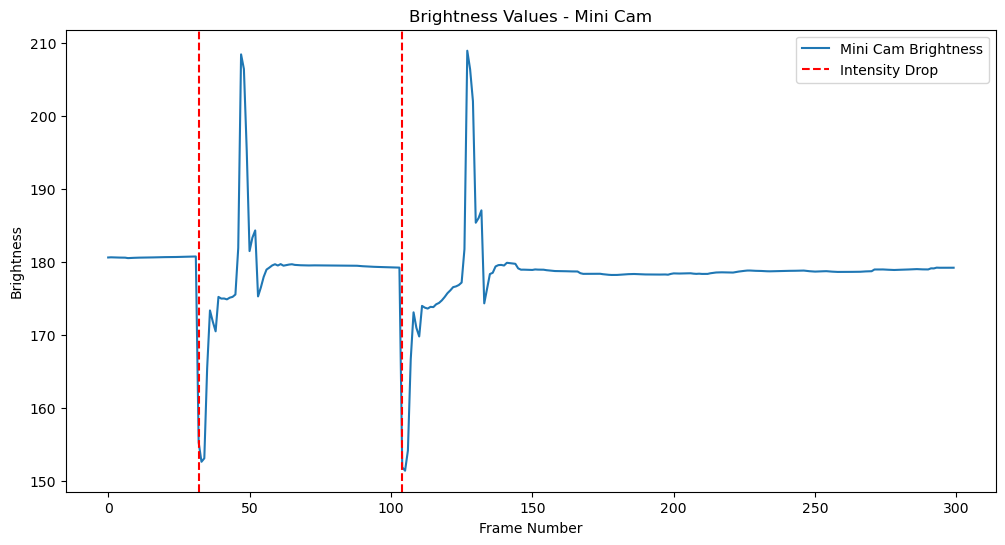

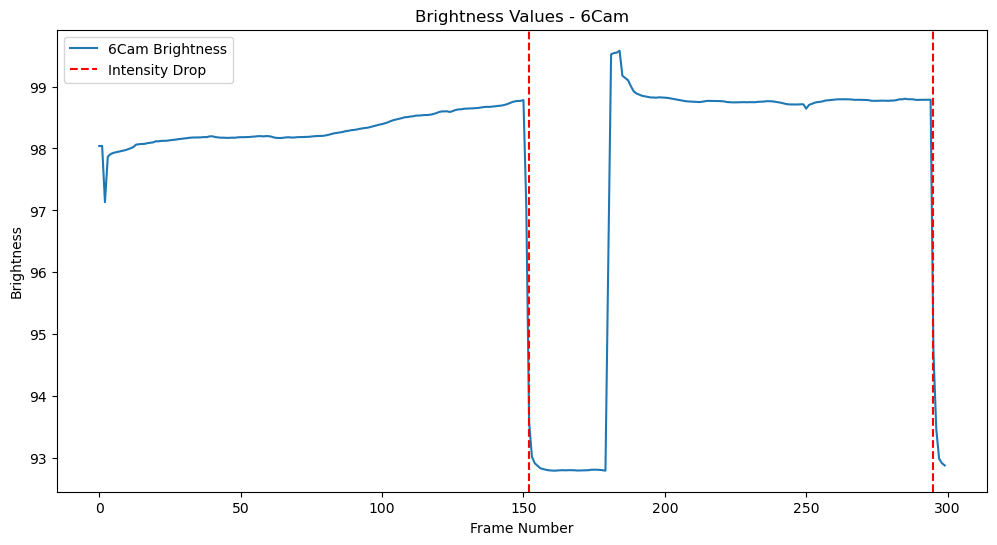

In [ ]:
# sync_videos.py

import os
import sys
sys.path.append(os.path.abspath('../..'))

    find_camera_with_frame_start,
    calculate_frame_brightness,
    find_brightness_drop,
    plot_brightness_values,
)

# Define paths
rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'

mini_cam_path = os.path.join(mini_path, 'My_First_WebCam')
mini_cam_vid = os.path.join(mini_cam_path, '0.avi')

miniscope_path = os.path.join(mini_path, 'My_V4_Miniscope')
miniscope_timestamps = os.path.join(miniscope_path, 'timeStamps.csv')

# Find the camera index with data_frame starting at 1
camera_index = find_camera_with_frame_start(rec_path)
if camera_index is None:
    raise ValueError("No valid camera index found.")

# Set the frame range for processing
max_frames_mini = 300  # Adjust as needed
min_frames_mini = 0

# Calculate frame brightness for mini cam video
brightness_values_mini = calculate_frame_brightness(mini_cam_vid, max_frames_mini, min_frames_mini)

# Construct the video path for the selected camera
camera_number = camera_index + 1  # If camera indices start from 0
sixcam_video_path = f'{rec_path}/videos/Camera{camera_number}/0.mp4'

# Check if the sixcam video exists
if not os.path.exists(sixcam_video_path):
    raise FileNotFoundError(f"6Cam video not found at {sixcam_video_path}")

# Set the frame range for processing
max_frames_sixcam = 300  # Adjust as needed
min_frames_sixcam = 0

# Calculate frame brightness for sixcam video
brightness_values_sixcam = calculate_frame_brightness(sixcam_video_path, max_frames_sixcam, min_frames_sixcam)

# Define thresholds (adjust based on your data)
threshold_mini = 20  # Example value
threshold_sixcam = 3  # Example value

# Find intensity drops
drop_indices_mini = find_brightness_drop(brightness_values_mini, threshold_mini)
print(f"Intensity drops in mini_cam_vid at frames: {drop_indices_mini}")

drop_indices_sixcam = find_brightness_drop(brightness_values_sixcam, threshold_sixcam)
print(f"Intensity drops in sixcam_video at frames: {drop_indices_sixcam}")

# Print synchronization frames
if drop_indices_mini:
    sync_frame_mini = drop_indices_mini[0]
    print(f"Synchronization frame in mini_cam_vid: {sync_frame_mini}")
else:
    print("No intensity drop found in mini_cam_vid.")

if drop_indices_sixcam:
    sync_frame_sixcam = drop_indices_sixcam[0]
    print(f"Synchronization frame in sixcam_video: {sync_frame_sixcam}")
else:
    print("No intensity drop found in sixcam_video.")

# Plotting for verification
# Mini Cam
plot_brightness_values(
    brightness_values_mini,
    drop_indices_mini,
    title='Brightness Values - Mini Cam',
    label='Mini Cam Brightness',
)

# 6Cam
plot_brightness_values(
    brightness_values_sixcam,
    drop_indices_sixcam,
    title='Brightness Values - 6Cam',
    label='6Cam Brightness',
)


Camera index with data_frame starting at 1: 0


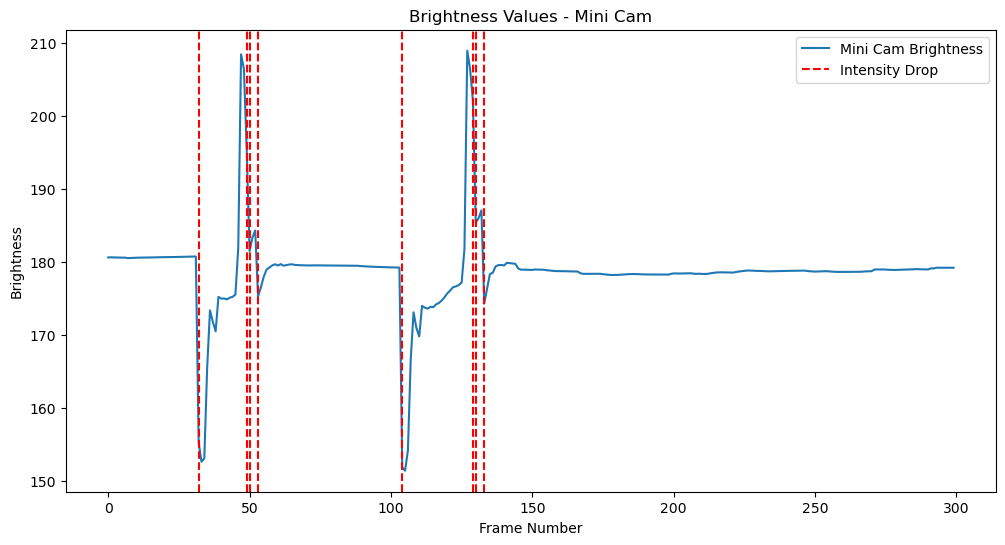

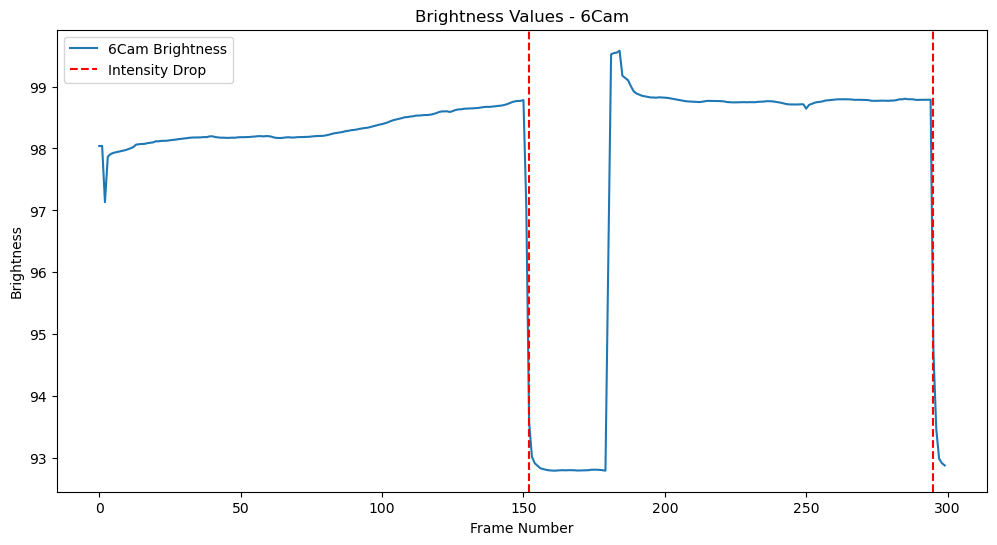

{'sync_frame_mini': 32,
 'sync_frame_sixcam': 152,
 'drop_indices_mini': [32, 49, 50, 53, 104, 129, 130, 133],
 'drop_indices_sixcam': [152, 295]}

In [ ]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.mini_dannce_sync import sync_videos


rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'
sync_videos(
    rec_path,
    mini_path,
    start_frame=0,
    end_frame=300,
    threshold_mini=20,
    threshold_sixcam=3
)

In [ ]:


# miniscope_vid = os.path.join(miniscope_path, '0.avi')


miniscope_timestamps_ms = load_mini_timestamps(miniscope_timestamps)
